<a href="https://colab.research.google.com/github/juvana81/CODSOFT/blob/main/Movie_Rating_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import gc
gc.collect()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"



In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline  # For creating a pipeline of transformations
from sklearn.impute import SimpleImputer  # For handling missing values
from sklearn.ensemble import RandomForestRegressor  # For Random Forest regression model
from sklearn.linear_model import LinearRegression  # For Linear regression model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # For model evaluation
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output


# ***Loading and Exploring The Dataset***

In [7]:
from google.colab import files
uploaded = files.upload()

Saving IMDb Movies India.csv to IMDb Movies India.csv


In [8]:
import pandas as pd
df = pd.read_csv('/content/IMDb Movies India.csv',encoding='latin-1')
df = df.sample(1000)

In [9]:
print("\n--- DATASET OVERVIEW ---")
print("\nFirst 5 rows of our dataset:")
print(df.head())


--- DATASET OVERVIEW ---

First 5 rows of our dataset:
                             Name    Year Duration                     Genre  \
14816                   Veerappan  (2016)  125 min  Action, Biography, Crime   
3196                College Kanya  (1935)      NaN                     Drama   
14193  The Other Side of the Door  (2016)   96 min                    Horror   
13333               Sohni Mahiwal  (1946)      NaN                       NaN   
8456                 Maan Maryada  (1984)  139 min                    Action   

       Rating   Votes          Director              Actor 1  \
14816     5.3     711   Ram Gopal Varma        Sachiin Joshi   
3196      NaN     NaN      Jayant Desai              Madhuri   
14193     5.3  17,337  Johannes Roberts  Sarah Wayne Callies   
13333     NaN     NaN         Ishwarlal      Ravindra Jaykar   
8456      3.7      13        R.P. Swamy     Naseeruddin Shah   

                 Actor 2          Actor 3  
14816  Sandeep Bharadwaj      Usha

In [10]:
print("\nDataset information:")
print(df.info())


Dataset information:
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 14816 to 2783
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      1000 non-null   object 
 1   Year      971 non-null    object 
 2   Duration  477 non-null    object 
 3   Genre     873 non-null    object 
 4   Rating    514 non-null    float64
 5   Votes     515 non-null    object 
 6   Director  961 non-null    object 
 7   Actor 1   896 non-null    object 
 8   Actor 2   838 non-null    object 
 9   Actor 3   794 non-null    object 
dtypes: float64(1), object(9)
memory usage: 85.9+ KB
None


In [11]:
print("\nSummary statistics:")
print(df.describe())


Summary statistics:
           Rating
count  514.000000
mean     5.727626
std      1.357520
min      1.600000
25%      4.900000
50%      5.800000
75%      6.700000
max      9.400000


In [12]:
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
Name          0
Year         29
Duration    523
Genre       127
Rating      486
Votes       485
Director     39
Actor 1     104
Actor 2     162
Actor 3     206
dtype: int64


In [13]:
print("/n No of unique Directors",df['Director'].nunique())
print("/n No of unique Genres",df['Genre'].nunique())

/n No of unique Directors 799
/n No of unique Genres 138


# ***Data cleaning and Preprocessing***

In [14]:
import numpy as np
import pandas as pd

if df.isnull().sum().sum() > 0:
    print("\n--- HANDLING MISSING VALUES ---")

    # STEP 1: Convert 'Year' to numeric if needed
    if df['Year'].dtype != np.number:
        df['Year'] = pd.to_numeric(df['Year'].astype(str).str.extract('(\d+)')[0], errors='coerce')
    if df['Year'].isnull().sum() > 0:
        df['Year'] = df['Year'].fillna(df['Year'].median())

    # STEP 2: Clean 'Duration' column
    df['Duration'] = df['Duration'].astype(str).str.replace('min', '').str.strip()
    df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')
    if df['Duration'].isnull().sum() > 0:
        df['Duration'] = df['Duration'].fillna(df['Duration'].median())

    # STEP 3: Convert 'Rating' and 'Votes' to numeric
    df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
    if df['Rating'].isnull().sum() > 0:
        df['Rating'] = df['Rating'].fillna(df['Rating'].median())

    df['Votes'] = pd.to_numeric(df['Votes'], errors='coerce')
    if df['Votes'].isnull().sum() > 0:
        df['Votes'] = df['Votes'].fillna(df['Votes'].median())

    # STEP 4: Handle 'Genre', 'Director', 'Actor 1/2/3' (Categorical)
    categorical_cols = ['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']
    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0])  # replace NaN with mode (most frequent)

    print("✅ Missing values handled successfully.")



--- HANDLING MISSING VALUES ---
✅ Missing values handled successfully.


# ***Exploratary Data Analysis***

Histogram to understand the distribution of ratings

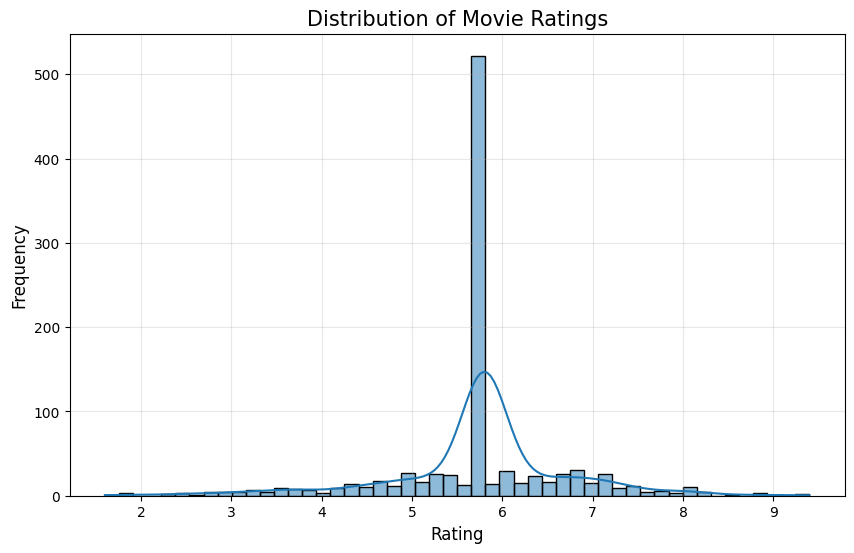

Rating Distribution Analysis:
- Average rating: 5.76
- Median rating: 5.80
- Most common rating range: 5.8
- Rating range: 1.6 to 9.4


In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Rating'], kde=True, bins=50)
plt.title('Distribution of Movie Ratings', fontsize=15)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print("Rating Distribution Analysis:")
print(f"- Average rating: {df['Rating'].mean():.2f}")
print(f"- Median rating: {df['Rating'].median():.2f}")
print(f"- Most common rating range: {df['Rating'].value_counts().idxmax()}")
print(f"- Rating range: {df['Rating'].min()} to {df['Rating'].max()}")

Understanding the relation between movie timimg and the rating(scatter plot). this is done to find wheather rating is dependent on the Duration or not

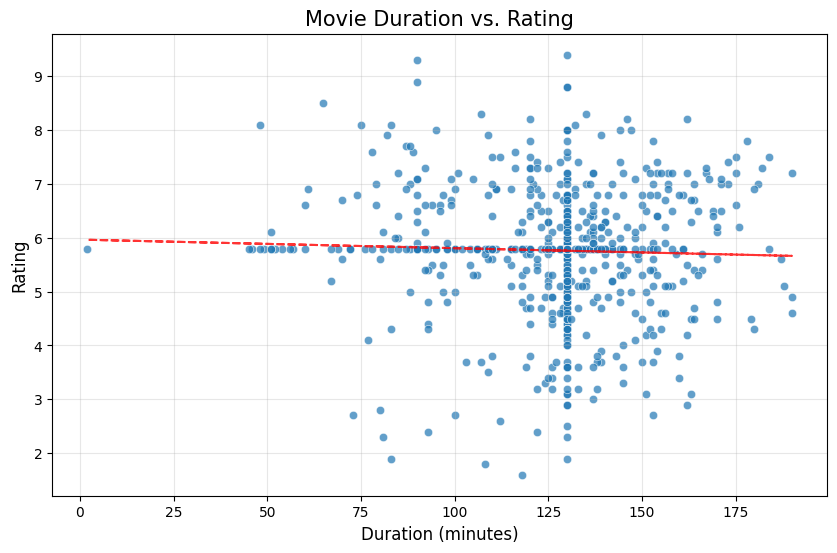


Correlation between Duration and Rating: -0.034
This suggests a weak relationship between movie duration and ratings.


In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Duration', y='Rating', data=df, alpha=0.7)
plt.title('Movie Duration vs. Rating', fontsize=15)
plt.xlabel('Duration (minutes)', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.grid(True, alpha=0.3)


#Adding  a tredline
z = np.polyfit(df['Duration'], df['Rating'], 1)
p = np.poly1d(z)
plt.plot(df['Duration'], p(df['Duration']), "r--", alpha=0.8)
plt.show()


#Calculate corelation between the movie rating and the duration
duration_rating_corr = df['Duration'].corr(df['Rating'])
print(f"\nCorrelation between Duration and Rating: {duration_rating_corr:.3f}")
if abs(duration_rating_corr) < 0.3:
    print("This suggests a weak relationship between movie duration and ratings.")
elif abs(duration_rating_corr) < 0.7:
    print("This suggests a moderate relationship between movie duration and ratings.")
else:
    print("This suggests a strong relationship between movie duration and ratings.")

Analysing Ratings by year using Line plot.

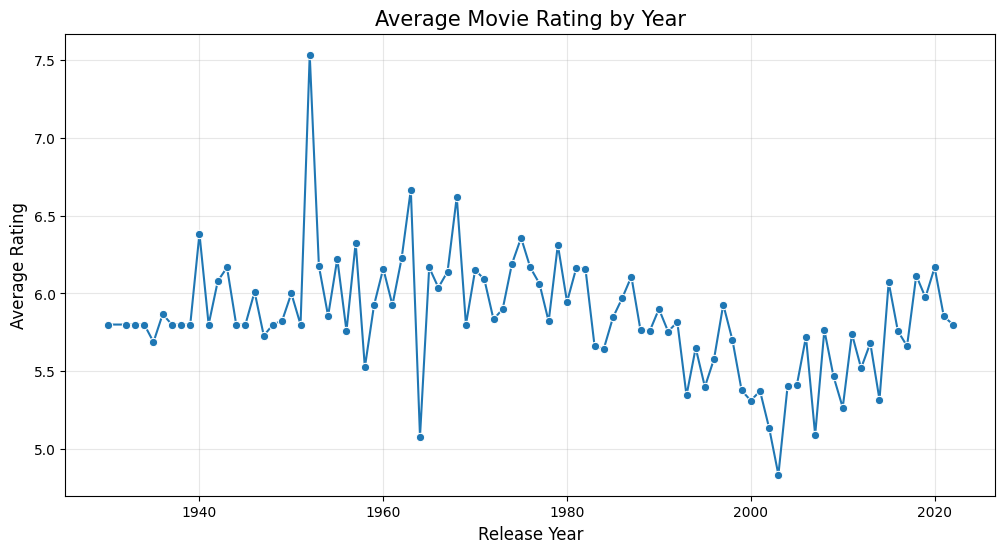


Rating Trends Over Time:
- Average rating in 1930.0: 5.80
- Average rating in 1976: 6.17
- Average rating in 2022.0: 5.80
- Overall trend: Ratings have decreased by 0.00 points


In [17]:
plt.figure(figsize=(12, 6))
year_ratings = df.groupby('Year')['Rating'].mean().reset_index()
sns.lineplot(x='Year', y='Rating', data=year_ratings, marker='o')
plt.title('Average Movie Rating by Year', fontsize=15)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Find trends over time
earliest_year = year_ratings['Year'].min()
middle_year = int(year_ratings['Year'].median())
latest_year = year_ratings['Year'].max()
earliest_rating = year_ratings[year_ratings['Year'] == earliest_year]['Rating'].values[0]
middle_rating = year_ratings[year_ratings['Year'] == middle_year]['Rating'].values[0]
latest_rating = year_ratings[year_ratings['Year'] == latest_year]['Rating'].values[0]

print(f"\nRating Trends Over Time:")
print(f"- Average rating in {earliest_year}: {earliest_rating:.2f}")
print(f"- Average rating in {middle_year}: {middle_rating:.2f}")
print(f"- Average rating in {latest_year}: {latest_rating:.2f}")
if latest_rating > earliest_rating:
    print(f"- Overall trend: Ratings have increased by {latest_rating - earliest_rating:.2f} points")
else:
    print(f"- Overall trend: Ratings have decreased by {earliest_rating - latest_rating:.2f} points")

Undertsanding the average rating according to the Genre using Bar plot.

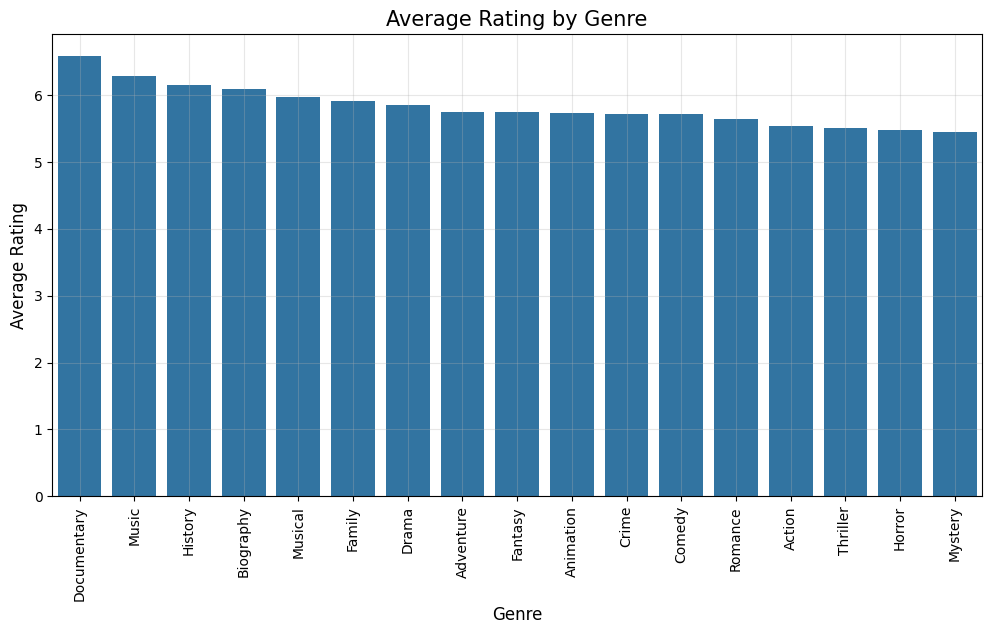


Top 5 Highest-Rated Genres:
                 mean  count
Genre                       
Documentary  6.583333     24
Music        6.280000      5
History      6.153846     13
Biography    6.100000     10
Musical      5.976923     39

Bottom 5 Lowest-Rated Genres:
              mean  count
Genre                    
Romance   5.641875    160
Action    5.546610    236
Thriller  5.515152     99
Horror    5.473529     34
Mystery   5.450000     30


In [18]:
genres_df = df.copy()
genres_df['Genre'] = genres_df['Genre'].str.split(',')
genres_df = genres_df.explode('Genre')
genres_df['Genre'] = genres_df['Genre'].str.strip()

# Get average rating by genre
genre_ratings = genres_df.groupby('Genre')['Rating'].agg(['mean', 'count']).sort_values('mean', ascending=False)
genre_ratings = genre_ratings[genre_ratings['count'] >= 5]  # Filter genres with at least 5 movies

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_ratings.index, y=genre_ratings['mean'])
plt.title('Average Rating by Genre', fontsize=15)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True, alpha=0.3)
plt.show()

print("\nTop 5 Highest-Rated Genres:")
print(genre_ratings.head(5))

print("\nBottom 5 Lowest-Rated Genres:")
print(genre_ratings.tail(5))

Analysing top directors by average rating using Bar Plot.

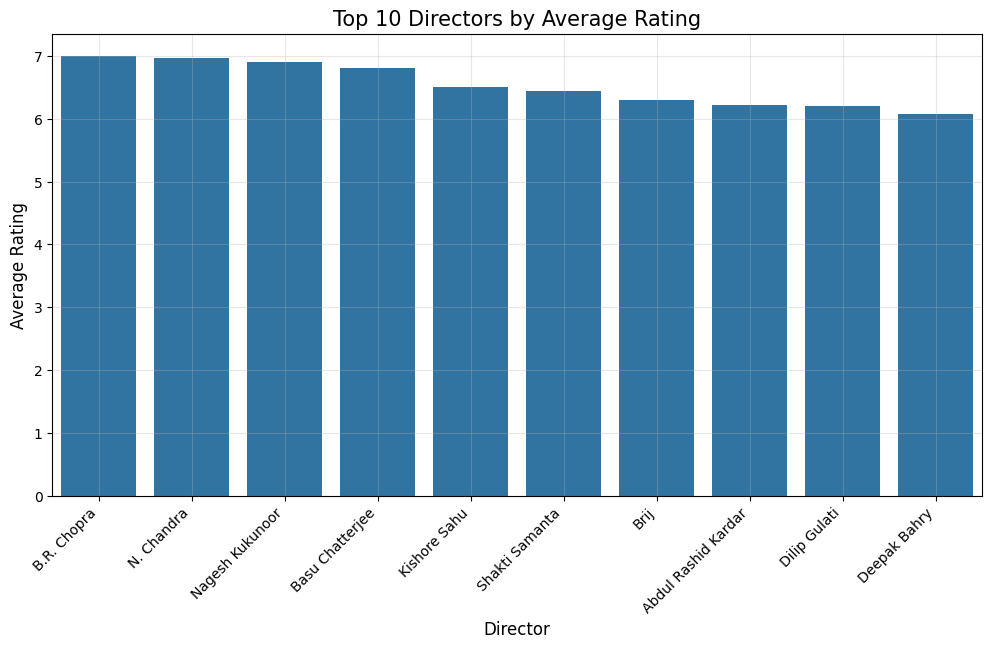


Top 5 Directors by Average Rating (min 3 movies):
                     mean  count
Director                        
B.R. Chopra      7.000000      3
N. Chandra       6.966667      3
Nagesh Kukunoor  6.900000      3
Basu Chatterjee  6.800000      4
Kishore Sahu     6.500000      3


In [19]:
director_ratings = df.groupby('Director')['Rating'].agg(['mean', 'count']).sort_values('mean', ascending=False)
director_ratings = director_ratings[director_ratings['count'] >= 3]  # Filter directors with at least 3 movies

plt.figure(figsize=(12, 6))
sns.barplot(x=director_ratings.index[:10], y=director_ratings['mean'][:10])
plt.title('Top 10 Directors by Average Rating', fontsize=15)
plt.xlabel('Director', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.show()

print("\nTop 5 Directors by Average Rating (min 3 movies):")
print(director_ratings.head(5))

Analysing top Actors based on Ratings

In [20]:
def analyze_actor(actor_column):
    actor_ratings = df.groupby(actor_column)['Rating'].agg(['mean', 'count']).sort_values('mean', ascending=False)
    actor_ratings = actor_ratings[actor_ratings['count'] >= 3]  # Filter actors with at least 3 movies
    return actor_ratings.head(5)

print("\nTop 5 Lead Actors by Average Rating (min 3 movies):")
print(analyze_actor('Actor 1'))
print("\nTop 5 supporting Actors by Average Rating (min 3 movies):")
print(analyze_actor('Actor 2'))
print(analyze_actor('Actor 3'))


Top 5 Lead Actors by Average Rating (min 3 movies):
                   mean  count
Actor 1                       
Dilip Kumar    6.966667      3
Anupam Kher    6.933333      3
Kishore Kumar  6.800000      3
Shabana Azmi   6.700000      6
Ashok Kumar    6.690909     11

Top 5 supporting Actors by Average Rating (min 3 movies):
                      mean  count
Actor 2                          
Bina Rai          7.433333      3
Nana Patekar      7.233333      3
Madhuri Dixit     7.033333      3
Rishi Kapoor      7.033333      3
Naseeruddin Shah  6.966667      3
                      mean  count
Actor 3                          
Pran              7.320000      5
Amitabh Bachchan  7.300000      3
Shashikala        6.660000      5
Rekha             6.633333      3
Durga Khote       6.350000      4


Corelation between Votes and Rating

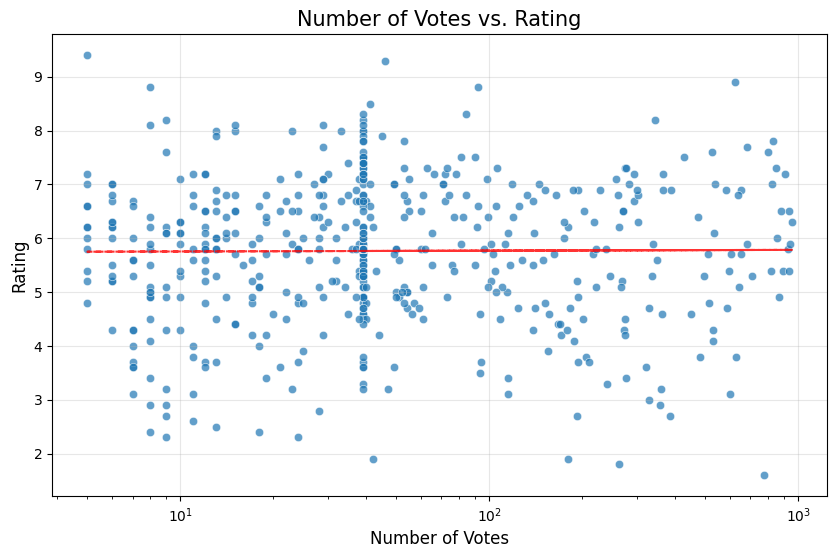


Correlation between Votes and Rating: -0.007
There's only a weak relationship between a movie's popularity and its rating.


In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Votes', y='Rating', data=df, alpha=0.7)
plt.title('Number of Votes vs. Rating', fontsize=15)
plt.xlabel('Number of Votes', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.xscale('log')  # Using log scale for better visualization
plt.grid(True, alpha=0.3)

votes_log = np.log10(df['Votes'].replace(0, 0.1))
z = np.polyfit(votes_log, df['Rating'], 1)
p = np.poly1d(z)
plt.plot(df['Votes'], p(votes_log), "r--", alpha=0.8)
plt.show()


votes_rating_corr = df['Votes'].corr(df['Rating'])
print(f"\nCorrelation between Votes and Rating: {votes_rating_corr:.3f}")
if votes_rating_corr > 0.3:
    print("This positive correlation suggests that popular movies (with more votes) tend to have higher ratings.")
elif votes_rating_corr < -0.3:
    print("This negative correlation suggests that popular movies (with more votes) tend to have lower ratings.")
else:
    print("There's only a weak relationship between a movie's popularity and its rating.")

Correlation heatmap of numerical features

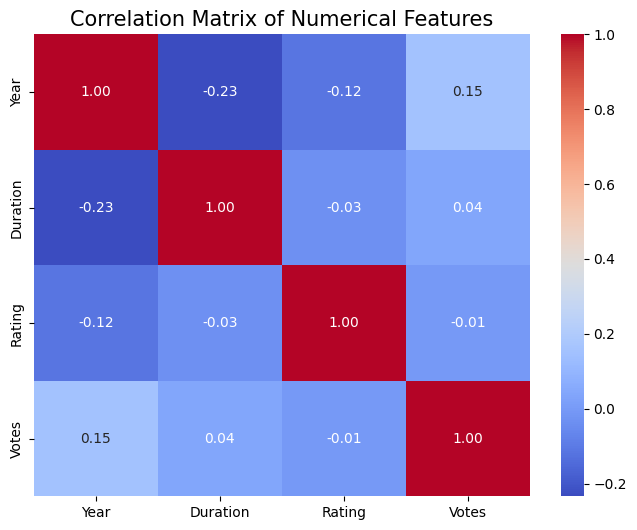


Key insights from correlation analysis:


In [22]:
plt.figure(figsize=(8, 6))
correlation_matrix = df[['Year', 'Duration', 'Rating', 'Votes']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features', fontsize=15)
plt.show()

print("\nKey insights from correlation analysis:")
for i, col1 in enumerate(['Year', 'Duration', 'Votes']):
    for col2 in ['Year', 'Duration', 'Votes', 'Rating'][i+1:]:
        corr = correlation_matrix.loc[col1, col2]
        if abs(corr) >= 0.3:
            strength = "strong" if abs(corr) >= 0.7 else "moderate"
            direction = "positive" if corr > 0 else "negative"
            print(f"- {strength} {direction} correlation ({corr:.2f}) between {col1} and {col2}")

# ***Feature Engineering***

Creating Features for Genres

In [23]:
def extract_genres(genre_string):
    """Extract individual genres from genre string and return as list"""
    if pd.isna(genre_string):
        return []
    return [g.strip() for g in genre_string.split(',')]

# Get all unique genres
all_genres = set()
for genre_list in df['Genre'].apply(extract_genres):
    all_genres.update(genre_list)

print(f"Found {len(all_genres)} unique genres. Creating binary features...")

# Create binary features for each genre
for genre in all_genres:
    df[f'genre_{genre}'] = df['Genre'].apply(lambda x: 1 if pd.notna(x) and genre in extract_genres(x) else 0)

Found 21 unique genres. Creating binary features...


Creating Features for directors

In [24]:
# Get directors who have directed at least 2 movies
top_directors = df['Director'].value_counts()[df['Director'].value_counts() >= 2].index
print(f"\nCreating binary features for {len(top_directors)} directors with 2+ movies...")

# Create binary column for each top director
for director in top_directors:
    df[f'director_{director}'] = (df['Director'] == director).astype(int)



Creating binary features for 110 directors with 2+ movies...


Creating Features for actors

In [25]:
def process_top_actors(actor_column, min_movies=2):
    top_actors = df[actor_column].value_counts()[df[actor_column].value_counts() >= min_movies].index
    print(f"Creating binary features for {len(top_actors)} {actor_column}s with {min_movies}+ movies...")

    for actor in top_actors:
        df[f'{actor_column}_{actor}'] = (df[actor_column] == actor).astype(int)

for actor_col in ['Actor 1', 'Actor 2', 'Actor 3']:
    process_top_actors(actor_col)


Creating binary features for 130 Actor 1s with 2+ movies...
Creating binary features for 104 Actor 2s with 2+ movies...
Creating binary features for 86 Actor 3s with 2+ movies...


Creating features for actore-director collaborations

In [26]:
collaborations = []
for _, row in df.iterrows():
    for actor_col in ['Actor 1', 'Actor 2', 'Actor 3']:
        collaborations.append((row[actor_col], row['Director']))

# Get top collaborations
from collections import Counter
top_collabs = [collab for collab, count in Counter(collaborations).most_common(10) if count >= 2]

print(f"\nCreating binary features for {len(top_collabs)} frequent actor-director collaborations...")
for actor, director in top_collabs:
    collab_name = f"collab_{actor}_{director}".replace(" ", "_")
    df[collab_name] = ((df['Actor 1'] == actor) | (df['Actor 2'] == actor) |
                       (df['Actor 3'] == actor)) & (df['Director'] == director)
    df[collab_name] = df[collab_name].astype(int)


Creating binary features for 10 frequent actor-director collaborations...


Creating Features for decades

In [27]:
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['decade'] = (df['Year'] // 10) * 10
decade_dummies = pd.get_dummies(df['decade'], prefix='decade')
df = pd.concat([df, decade_dummies], axis=1)


Creating Features for duration

In [28]:
df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')
df['Duration'] = df['Duration'].fillna(df['Duration'].median())
bins = [0, 90, 120, 150, 300]
labels = ['Short', 'Medium', 'Long', 'Very Long']
df['duration_category'] = pd.cut(df['Duration'], bins=bins, labels=labels)
duration_dummies = pd.get_dummies(df['duration_category'], prefix='duration')
df = pd.concat([df, duration_dummies], axis=1)

In [29]:
print(f"\nDataset after feature engineering has {df.shape[1]} columns")
print(f"New features added: {df.shape[1] - 10}")


Dataset after feature engineering has 487 columns
New features added: 477


# ***Model Building and model Evaluation***

## **Preparing Data for modelling**

In [30]:

exclude_cols = ['Name', 'Rating', 'decade', 'duration_category']

# Keep Genre, Director, Actor1, etc. — we'll encode them later
feature_cols = [col for col in df.columns if col not in exclude_cols]

# Clean 'Votes' column (remove commas and convert to numeric)
df['Votes'] = pd.to_numeric(df['Votes'].replace(',', '', regex=True), errors='coerce')

# Define X and y
X = df[feature_cols]
y = df['Rating']

print(f"Total features used: {len(feature_cols)}")
print(f"Sample features: {feature_cols[:5]}")



Total features used: 483
Sample features: ['Year', 'Duration', 'Genre', 'Votes', 'Director']


In [31]:
# Expand genres into multiple binary columns (only once)
if 'Genre' in df.columns:
    genres_expanded = df['Genre'].str.get_dummies(sep=', ')
    df = pd.concat([df, genres_expanded.add_prefix('genre_')], axis=1)
    df.drop('Genre', axis=1, inplace=True)
    print("✅ Genre expanded and original column dropped.")
else:
    print("⚠️ Genre column already dropped. Skipping this step.")

# Define features and target
y = df['Rating']
X = df.drop('Rating', axis=1)
X = X.loc[:, ~X.columns.duplicated()]

# Identify genre columns
genre_columns = [col for col in X.columns if col.startswith('genre_')]

# Define numerical and categorical features
numerical_features = ['Year', 'Duration', 'Votes'] + genre_columns
categorical_features = [col for col in X.columns if col not in numerical_features]


# Show duplicated column names
duplicated_columns = X.columns[X.columns.duplicated()]
print("🛑 Duplicated columns:", duplicated_columns.tolist())

# Ensure column names are unique
assert X.columns.is_unique, "❌ Column names are not unique!"

# Numerical pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine both into one preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

print("\n✅ Genre one-hot encoded and preprocessing pipeline constructed cleanly.")





✅ Genre expanded and original column dropped.
🛑 Duplicated columns: []

✅ Genre one-hot encoded and preprocessing pipeline constructed cleanly.


In [32]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


Training set size: 800 samples
Testing set size: 200 samples


## **Model Building and evaluation**

In [33]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

In [34]:
results = {}

for name, model in models.items():
    print(f"\n--- Training {name} model ---")

    # Create pipeline with preprocessing and model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)



--- Training Linear Regression model ---

--- Training Random Forest model ---


In [35]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

    # Store results
results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

    # Print metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error (MSE): 0.8222
Root Mean Squared Error (RMSE): 0.9068
Mean Absolute Error (MAE): 0.5099
R² Score: 0.0968


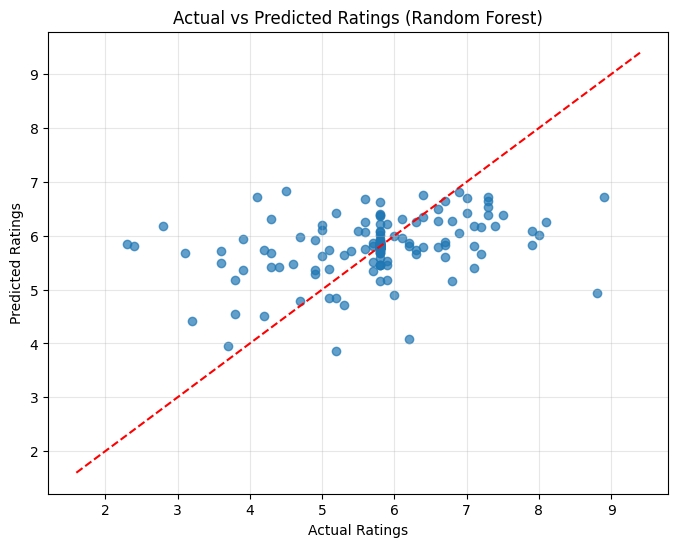

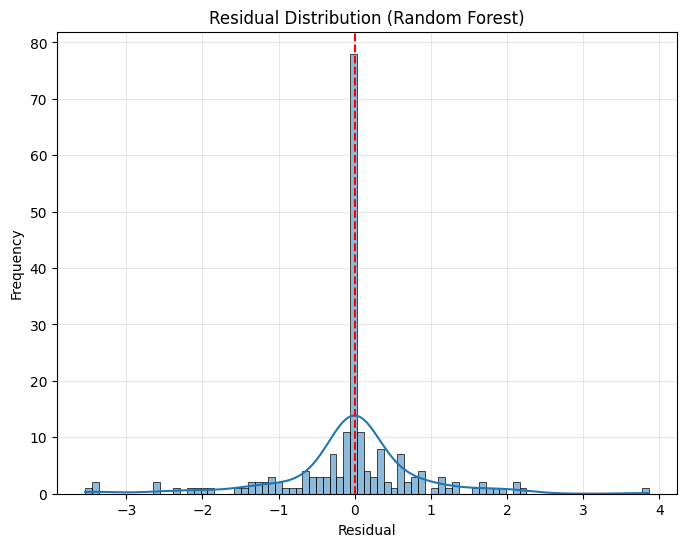

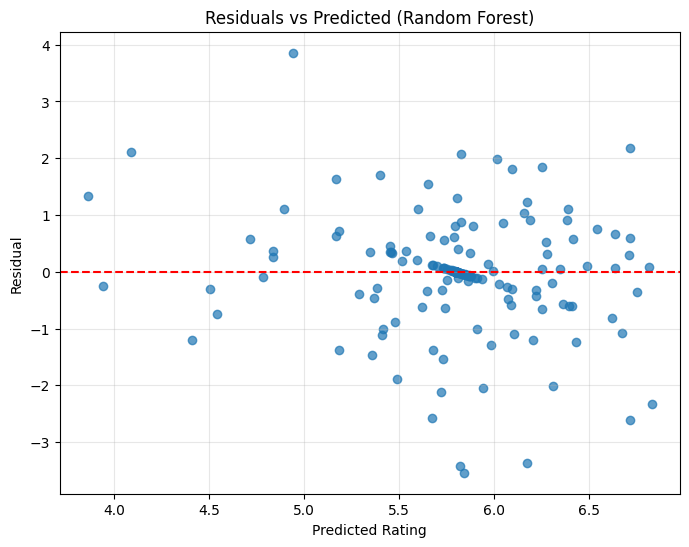

In [36]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title(f'Actual vs Predicted Ratings ({name})')
plt.grid(True, alpha=0.3)
plt.show()

    # Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title(f'Residual Distribution ({name})')
plt.grid(True, alpha=0.3)
plt.show()

    # Additional residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Rating')
plt.ylabel('Residual')
plt.title(f'Residuals vs Predicted ({name})')
plt.grid(True, alpha=0.3)
plt.show()



Model Performance Comparison:
                    MSE      RMSE       MAE        R2
Random Forest  0.822212  0.906759  0.509925  0.096824


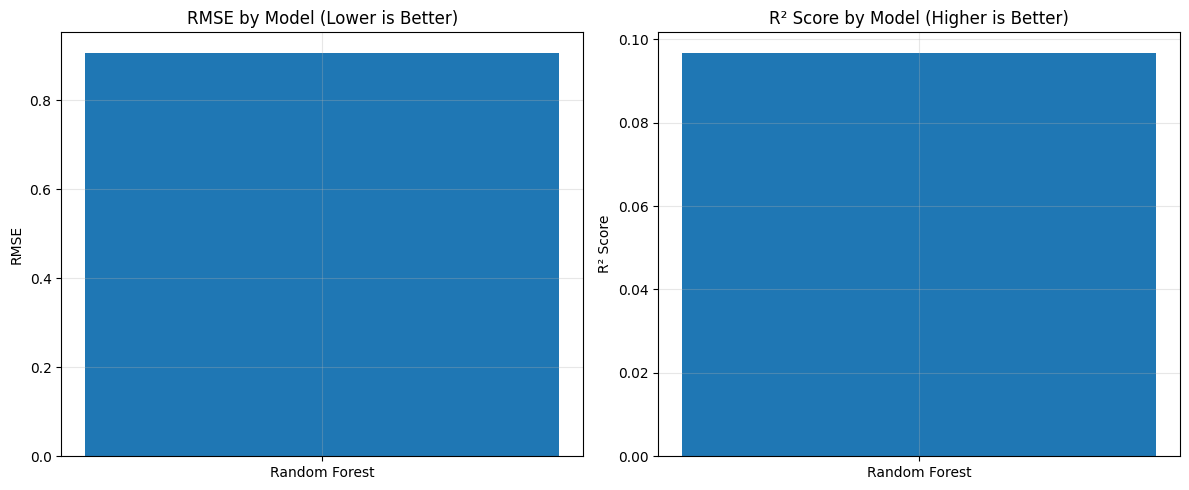


The best performing model is Random Forest with an R² score of 0.0968


In [37]:
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(results_df.index, results_df['RMSE'])
plt.title('RMSE by Model (Lower is Better)')
plt.ylabel('RMSE')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(results_df.index, results_df['R2'])
plt.title('R² Score by Model (Higher is Better)')
plt.ylabel('R² Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_model_name = results_df['R2'].idxmax()
print(f"\nThe best performing model is {best_model_name} with an R² score of {results_df.loc[best_model_name, 'R2']:.4f}")

# **Using model for prediction**

In [41]:
def prepare_movie_features(movie_data, all_features):
    """
    Prepare a movie's data for prediction by ensuring it has all required features.

    Parameters:
    movie_data: Dictionary with movie information
    all_features: List of all features used in model training

    Returns:
    DataFrame with one row, all required features, aligned to training columns
    """
    movie_df = pd.DataFrame([movie_data])

    # Handle Genre expansion (binary columns)
    if 'Genre' in movie_df.columns:
        genres = movie_df['Genre'].iloc[0].split(',')
        for genre in [col.replace('genre_', '') for col in all_features if col.startswith('genre_')]:
            movie_df[f'genre_{genre}'] = 1 if genre.strip() in genres else 0
        movie_df.drop('Genre', axis=1, inplace=True)

    # Fill missing columns from training with 0
    for col in all_features:
        if col not in movie_df.columns:
            movie_df[col] = 0

    # Reorder columns to match training
    return movie_df[all_features]


In [43]:
# Define the new movie data
new_movie = {
    'Name': 'New Bollywood Movie',
    'Year': 2023,
    'Duration': 145,
    'Genre': 'Action,Drama,Thriller',
    'Votes': 0,  # New movie, no votes yet
    'Director': 'New Director',
    'Actor1': 'Famous Actor',
    'Actor2': 'Supporting Actor',
    'Actor3': 'Character Actor'
}

# Drop 'Name' as it’s unused in model
if 'Name' in new_movie:
    new_movie.pop('Name')
# Save the list of training column names for prediction later
training_columns = X.columns.tolist()

# Prepare features
new_movie_features = prepare_movie_features(new_movie, training_columns)

# Predict
predicted_rating = best_pipeline.predict(new_movie_features)[0]
print(f"\n🎬 Predicted rating for the new movie: {predicted_rating:.2f}/10")



🎬 Predicted rating for the new movie: 6.09/10
